# Preamble for R

In [1]:
libraries = c("dplyr","magrittr","tidyr","ggplot2","readxl","knitr","zoo","gridExtra","RColorBrewer")
for(x in libraries) {
    library(x,character.only=TRUE,warn.conflicts=FALSE) }

# options(jupyter.plot_mimetypes = "image/svg+xml") 
clrs = brewer.pal(8,"Set1")

# Initialization of array for recorded plots
plot_point_sizes <- c(); nm <- c(); plot_point_sizes <- list()

'%&%' <- function(x,y)paste0(x,y)
'%!in%' <- function(x,y)!('%in%'(x,y))

# Processing the data

## Importing the data from Excel file

### Categories of the data
* **Year** = year under record
* **Week** = the last week included in the record
* **LGAs** = number of LGAs affected by the epidemic (presumably for Nigeria)
* **States** = number of states affected by the epidemic
* **Reported cases** = cases of infection reported by the clinic
* **Deaths** = reported (suspected + confirmed) death cases
* **Confirmed** = cases of infection confirmed by the laboratory

In [3]:
data_file = "../data/Raw data/Nigeria_before_PlotDigitizer.xlsx"
read_excel(data_file,sheet="Incidence") %>% select(-Source) -> data 
data %>% tail(20)

Year,Week,LGAs,States,Reported,Deaths,Confirmed
2011,13,NA,NA,NA,NA,NA
2011,12,NA,NA,NA,NA,NA
2011,11,NA,NA,NA,NA,NA
2011,10,NA,NA,NA,NA,NA
2011,9,NA,NA,NA,NA,NA
2011,8,NA,NA,NA,NA,NA
2011,7,NA,NA,NA,NA,NA
2011,6,NA,NA,NA,NA,NA
2011,5,NA,NA,NA,NA,NA
2011,4,NA,NA,NA,NA,NA


In [4]:
#range of years under consideration
yearMin = 2012; yearMax = 2017 
#define which years b/w yearMin and yearMax we have in our dataset
data$Year %>% unique %>% na.omit %>% .[order(.)] %>% .[yearMin<=.&.<=yearMax] -> yrs   
yrs

[1] 2012 2013 2014 2015 2016 2017

In [5]:
#function to get the list of Fridays for a given year
getFridays = function(year,is_the_first_weekday_Monday=TRUE) {
    starting_date = if_else((as.POSIXlt((year-1)%&%'-12-31')$wday-is_the_first_weekday_Monday)%%7<3,
                            as.Date(year%&%'-01-01'),as.Date(year%&%'-01-06'))
    finishing_date = if_else((as.POSIXlt(year%&%'-12-31')$wday-is_the_first_weekday_Monday)%%7<3,
                            as.Date(year%&%'-12-31'),as.Date((year+1)%&%'-01-04'))
    return(seq(starting_date,finishing_date,'days')%>%.[weekdays(.)=='Friday']) }

In [6]:
as.data.frame(yrs) %>% rowwise() %>% mutate("Number of weeks"=length(getFridays(yrs)))

yrs,Number of weeks
2012,52
2013,52
2014,52
2015,53
2016,52
2017,52


## Aggregating the data for all years

In [7]:
data %>% 
    filter(!is.na(Year)&!is.na(Week)&(yearMin<=Year)&(Year<yearMax)) %>% 
    group_by(Year) %>% 
    filter(Week==max(Week)) %>%
    arrange(Year) %>% 
    ungroup %>%
    mutate(Reported=cumsum(Reported),
           Deaths=cumsum(Deaths),
           Confirmed=cumsum(Confirmed)) -> df0
df0

Year,Week,LGAs,States,Reported,Deaths,Confirmed
2012,52,42,23,1723,112,201
2013,52,NA,NA,2918,151,362
2014,52,37,13,3907,187,472
2015,53,37,15,4337,227,497
2016,52,144,29,5265,349,612


In [8]:
data %>%
    filter(!is.na(Year)&!is.na(Week)&(yearMin<=Year)&(Year<=yearMax)) %>%
    rowwise() %>%
    mutate(Reported=Reported+if_else(Year>yearMin,as.numeric(df0[which(df0['Year']==Year-1),'Reported']),0),
          Deaths=Deaths+if_else(Year>yearMin,as.numeric(df0[which(df0['Year']==Year-1),'Deaths']),0),
          Confirmed=Confirmed+if_else(Year>yearMin,as.numeric(df0[which(df0['Year']==Year-1),'Confirmed']),0),
          Date=getFridays(Year)[Week]) %>%
    arrange(Year,Week) -> df.wide
df.wide %>% tail(12)

Year,Week,LGAs,States,Reported,Deaths,Confirmed,Date
2016,50,143,29,5248,343,597,2016-12-16
2016,51,144,29,5258,346,608,2016-12-23
2016,52,144,29,5265,349,612,2016-12-30
2017,1,NA,NA,NA,349,614,2017-01-06
2017,2,NA,NA,NA,351,618,2017-01-13
2017,3,NA,NA,5363,356,626,2017-01-20
2017,4,20,10,5372,358,630,2017-01-27
2017,5,27,10,5403,370,649,2017-02-03
2017,6,29,10,5411,372,650,2017-02-10
2017,7,NA,10,5419,374,651,2017-02-17


In [9]:
#Different types of factors
Cases = c("Reported","Deaths","Confirmed")
Coverage = c("LGAs","States")
#Transforming to the long form
df.wide %>% 
    gather(Category,Count,-Date,-Year,-Week) %>%
    mutate(Category=factor(Category,levels=c(Cases,Coverage))) %>%
    na.omit -> df
tail(df)

Year,Week,Date,Category,Count
2017,4,2017-01-27,Confirmed,630
2017,5,2017-02-03,Confirmed,649
2017,6,2017-02-10,Confirmed,650
2017,7,2017-02-17,Confirmed,651
2017,8,2017-02-24,Confirmed,657
2017,9,2017-03-03,Confirmed,661


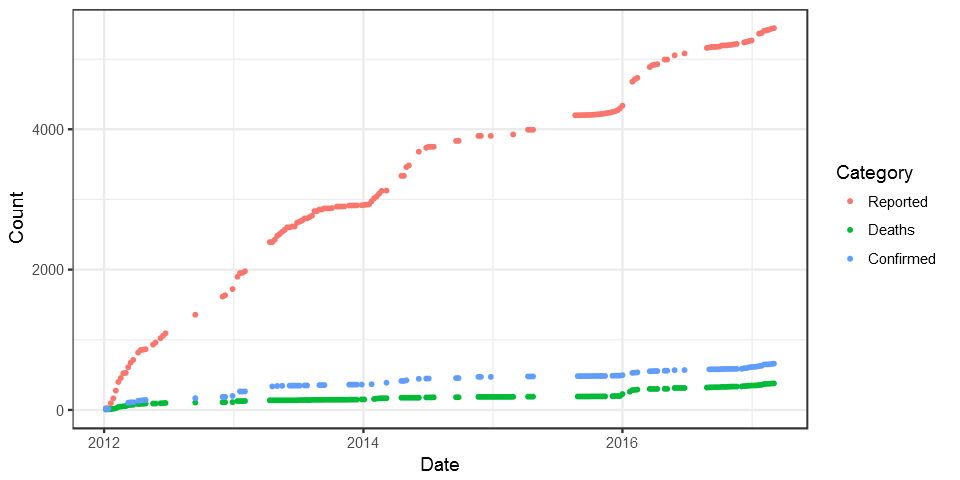

In [10]:
options(repr.plot.width=8,repr.plot.height=4)
df %>% 
    filter(Category %in% Cases) %>%
    ggplot(group=Category) +
        geom_point(aes(x=Date, y=Count, colour=Category), size=.6) + 
        theme_bw()

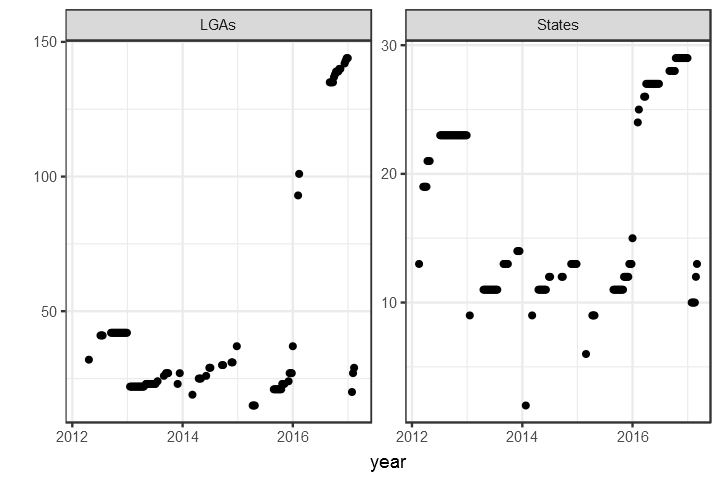

In [11]:
curr_size = c(6,4)
options(repr.plot.width=curr_size[1],repr.plot.height=curr_size[2])
par(mar=c(4,4.5,1.5,2)+.1)

df %>%
    filter(Category %in% Coverage) %>%
    ggplot(group=Category) + facet_wrap(~ Category,scales="free_y") +
        geom_point(aes(x=Date, y=Count), size=1.2) + 
        scale_size_area() + xlab("year") + ylab(" ") + theme_bw()

In [12]:
df.wide %<>%
    mutate(Reported.Incidence = if_else(Week>1,(Reported-lag(Reported))/(Week-lag(Week)),Reported)) %>%
    rename(Reported.Count = Reported)
tail(df.wide,12)

Year,Week,LGAs,States,Reported.Count,Deaths,Confirmed,Date,Reported.Incidence
2016,50,143,29,5248,343,597,2016-12-16,9
2016,51,144,29,5258,346,608,2016-12-23,10
2016,52,144,29,5265,349,612,2016-12-30,7
2017,1,NA,NA,NA,349,614,2017-01-06,NA
2017,2,NA,NA,NA,351,618,2017-01-13,NA
2017,3,NA,NA,5363,356,626,2017-01-20,NA
2017,4,20,10,5372,358,630,2017-01-27,9
2017,5,27,10,5403,370,649,2017-02-03,31
2017,6,29,10,5411,372,650,2017-02-10,8
2017,7,NA,10,5419,374,651,2017-02-17,8


# Data imputation from PlotDigitizing

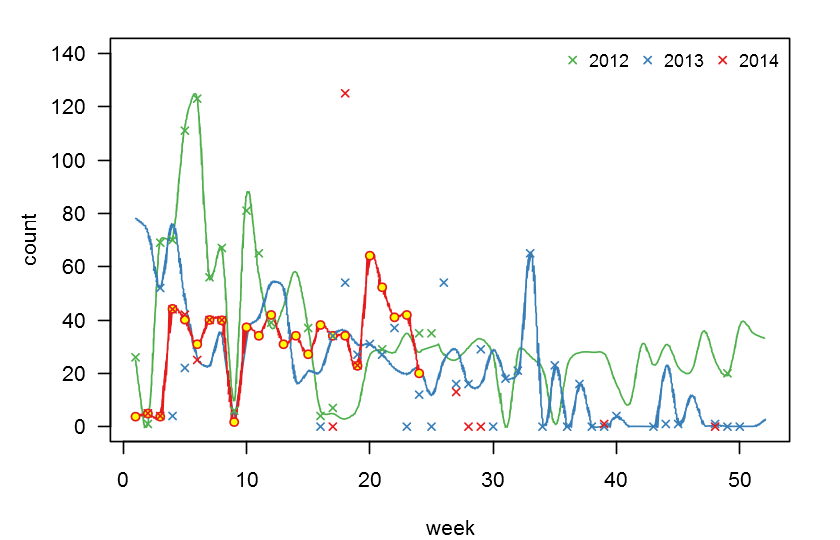

In [14]:
curr_size = c(7,4.5)
options(repr.plot.width=curr_size[1],repr.plot.height=curr_size[2])
par(mar=c(4,4.5,1.5,2)+.1,las=1)

yrs_to_digitize = c(2012,2013,2014)
# Color palette
clrs_ = c(clrs[3],clrs[2],clrs[1])

plot(0:1,xlim=c(1,52),ylim=c(0,140),xlab="week",ylab="count",type="n")

# Green curve from PlotDigitizer
data2012 = read.csv("../data/Raw data/plotDigitizer - green color.csv",header = FALSE)
data2012[,1] = data2012[,1]-.5
lines(data2012[,1],data2012[,2],col=clrs_[1])
# Blue curve
data2013 = read.csv("../data/Raw data/plotDigitizer - blue color.csv",header = FALSE)
data2013[,1] = data2013[,1]-.5
lines(data2013[,1],data2013[,2],col=clrs_[2])
# Red curve
data2014 = read.csv("../data/Raw data/plotDigitizer - red color.csv",header = FALSE)
data2014[,1] = data2014[,1]-.5
lines(data2014[,1],data2014[,2],col=clrs_[3])
# Red curve points
data2014b = read.csv("../data/Raw data/plotDigitizer - red color - points.csv",header = FALSE)
points(data2014b[,1],data2014b[,2],col=clrs_[3],pch=21,bg='yellow',cex=.8)

# Known points from EpiReports
k_ = 1
for(yr in yrs_to_digitize) {
    df.wide %>% filter(Year==yr) %>% select(Week,Reported.Incidence) %>% na.omit -> df_
    points(df_[['Week']],df_[['Reported.Incidence']],col=clrs_[k_],pch=4,cex=.8)
    k_ = k_ + 1
}

legend("topright", legend=yrs_to_digitize, col=clrs_, pch=4, bty="n", 
       pt.cex=.8, y.intersp=2.5, x.intersp=1, cex=.85, ncol=3)

## Imputed data for 2012

In [16]:
data2012

Week,Incidence
0.992036,24.914680
1.029488,24.290423
1.029488,23.041909
1.029488,23.666166
1.104391,21.793394
1.104391,21.169137
1.104391,22.417651
1.104391,20.544880
1.141842,19.764558
1.179294,18.359979


In [29]:
colnames(data2012) = c("Week","Incidence")
data.frame(Week=1:52) %>%
    full_join(data2012) %>% arrange(Week) -> df_
df_[,2] = na.approx(df_[,2],rule=2)
df_ %<>%
    filter(Week %in% 1:52)
df_ %>% head

Joining, by = "Week"


Week,Incidence
1,24.6025515
2,0.8807765
3,69.8872120
4,70.6025070
5,112.9349510
6,122.6109380


We use previous data from EpiReports unless it is different more than on 3 counts + we don't touch two data points from the weeks 24 and 25, because PlotDigitizing was not correct for them (see the picture above, two green points above the last red-yellow point)

In [30]:
df.wide %>% filter(Year==2012) %>% select(Week,Reported.Incidence) %>% na.omit -> df_Total
df_Total %<>% 
    right_join(df_) %>%
    right_join(data.frame(Week=1:52,Reported.Imputed=NA)) %>%
    mutate(Reported.Imputed = if_else(is.na(Reported.Incidence),
                                          Incidence,
                                          if_else((abs(Reported.Incidence-Incidence)<5)|(Week==24)|(Week==25),
                                                  Reported.Incidence,
                                                  Incidence)),
          Reported.Imputed.Rounded = round(Reported.Imputed,0))
df_Total

Joining, by = "Week"
Joining, by = "Week"


Week,Reported.Incidence,Incidence,Reported.Imputed,Reported.Imputed.Rounded
1,26,24.6025515,26.000000,26
2,1,0.8807765,1.000000,1
3,69,69.8872120,69.000000,69
4,70,70.6025070,70.000000,70
5,111,112.9349510,111.000000,111
6,123,122.6109380,123.000000,123
7,56,55.6593495,56.000000,56
8,67,65.1792720,67.000000,67
9,6,10.2836515,6.000000,6
10,81,86.3259860,86.325986,86


In [31]:
df_Total %>%
    select(Week,Reported.Imputed.Rounded) %>%
    rename(Incidence.Imputed = Reported.Imputed.Rounded) %>%
    mutate(Year=2012) -> df_Imputed
df_Imputed %>% head

Week,Incidence.Imputed,Year
1,26,2012
2,1,2012
3,69,2012
4,70,2012
5,111,2012
6,123,2012


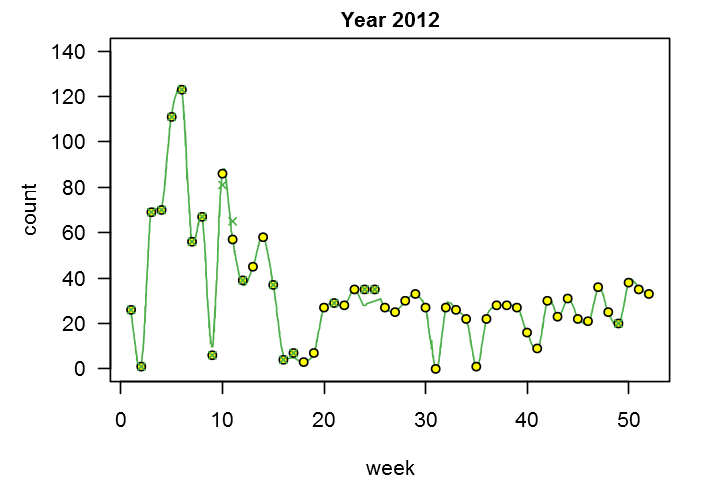

In [32]:
curr_size = c(6,4)
options(repr.plot.width=curr_size[1],repr.plot.height=curr_size[2])
par(mar=c(4,4.5,1.5,2)+.1,las=1)

plot(0:1,xlim=c(1,52),ylim=c(0,140),xlab="week",ylab="count",type="n",main="Year 2012",cex.main=1.02)

# from PlotDigitizer
lines(data2012[,1],data2012[,2],col=clrs_[1])

# Imputed data
df_Imputed %>% filter(Year==2012) -> df_
points(df_[['Week']],df_[['Incidence.Imputed']],col='black',bg='yellow',pch=21,cex=.8)

# Known points from EpiReports
df.wide %>% filter(Year==2012) %>% select(Week,Reported.Incidence) %>% na.omit -> df_
points(df_[['Week']],df_[['Reported.Incidence']],col=clrs_[1],pch=4,cex=.8)

## Imputed data for 2013

In [33]:
colnames(data2013) = c("Week","Incidence")
data.frame(Week=1:52) %>%
    full_join(data2013) %>% arrange(Week) -> df_
df_[,2] = na.approx(df_[,2],rule=2)
df_ %<>%
    filter(Week %in% 1:52)
df_ %>% head

Joining, by = "Week"


Week,Incidence
1,78.08059
2,73.06052
3,52.69413
4,75.68760
5,48.01220
6,26.31926


We use previous data from EpiReports unless it is different more than on 3 counts

In [34]:
df.wide %>% filter(Year==2013) %>% select(Week,Reported.Incidence) %>% na.omit -> df_Total
df_Total %<>% 
    right_join(df_) %>%
    right_join(data.frame(Week=1:52,Reported.Imputed=NA)) %>%
    mutate(Reported.Imputed = if_else(is.na(Reported.Incidence),
                                          Incidence,
                                          if_else(abs(Reported.Incidence-Incidence)<3,
                                                  Reported.Incidence,
                                                  Incidence)),
          Reported.Imputed.Rounded = round(Reported.Imputed,0))
df_Total

Joining, by = "Week"
Joining, by = "Week"


Week,Reported.Incidence,Incidence,Reported.Imputed,Reported.Imputed.Rounded
1,NA,78.0805880,78.0805880,78
2,NA,73.0605200,73.0605200,73
3,52,52.6941275,52.0000000,52
4,4,75.6876025,75.6876025,76
5,22,48.0121985,48.0121985,48
6,NA,26.3192590,26.3192590,26
7,NA,23.1199410,23.1199410,23
8,NA,33.6542815,33.6542815,34
9,NA,4.5092720,4.5092720,5
10,NA,21.8324105,21.8324105,22


In [35]:
df_Total %>%
    select(Week,Reported.Imputed.Rounded) %>%
    rename(Incidence.Imputed = Reported.Imputed.Rounded) %>%
    mutate(Year=2013) %>% rbind(df_Imputed) -> df_Imputed
df_Imputed %>% head

Week,Incidence.Imputed,Year
1,78,2013
2,73,2013
3,52,2013
4,76,2013
5,48,2013
6,26,2013


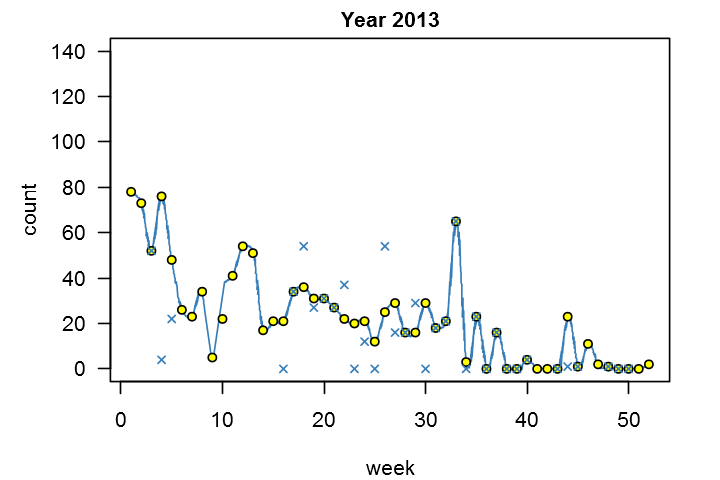

In [36]:
curr_size = c(6,4)
options(repr.plot.width=curr_size[1],repr.plot.height=curr_size[2])
par(mar=c(4,4.5,1.5,2)+.1,las=1)

plot(0:1,xlim=c(1,52),ylim=c(0,140),xlab="week",ylab="count",type="n",main="Year 2013",cex.main=1.02)

# from PlotDigitizer
lines(data2013[,1],data2013[,2],col=clrs_[2])

# Imputed data
df_Imputed %>% filter(Year==2013) -> df_
points(df_[['Week']],df_[['Incidence.Imputed']],col='black',bg='yellow',pch=21,cex=.8)

# Known points from EpiReports
df.wide %>% filter(Year==2013) %>% select(Week,Reported.Incidence) %>% na.omit -> df_
points(df_[['Week']],df_[['Reported.Incidence']],col=clrs_[2],pch=4,cex=.8)

## Imputed data for a part of 2014

In [21]:
colnames(data2014b) = c("Week","Incidence")
data.frame(data2014b) -> df_
df_

Week,Incidence
1,3.754513
2,4.909747
3,3.754513
4,44.187726
5,40.144404
6,30.902527
7,40.000000
8,39.855596
9,1.732852
10,37.256318


We use previous data from EpiReports unless it is different more than on 3 counts

In [22]:
df.wide %>% filter(Year==2014) %>% select(Week,Reported.Incidence) %>% na.omit -> df_Total
df_Total %<>% 
    right_join(df_) %>%
    right_join(data.frame(Week=1:max(data2014b[,1]),Reported.Imputed=NA)) %>%
    mutate(Reported.Imputed = if_else(is.na(Reported.Incidence),
                                          Incidence,
                                          if_else(abs(Reported.Incidence-Incidence)<3,
                                                  Reported.Incidence,
                                                  Incidence)),
          Reported.Imputed.Rounded = round(Reported.Imputed,0))
df_Total

Joining, by = "Week"
Joining, by = "Week"


Week,Reported.Incidence,Incidence,Reported.Imputed,Reported.Imputed.Rounded
1,2922,3.754513,3.754513,4
2,5,4.909747,5.000000,5
3,4,3.754513,4.000000,4
4,44,44.187726,44.000000,44
5,42,40.144404,42.000000,42
6,25,30.902527,30.902527,31
7,40,40.000000,40.000000,40
8,40,39.855596,40.000000,40
9,NA,1.732852,1.732852,2
10,NA,37.256318,37.256318,37


In [23]:
df_Total %>%
    select(Week,Reported.Imputed.Rounded) %>%
    rename(Incidence.Imputed = Reported.Imputed.Rounded) %>%
    mutate(Year=2014) %>% rbind(df_Imputed) -> df_Imputed
df_Imputed %>% head

Week,Incidence.Imputed,Year
1,4,2014
2,5,2014
3,4,2014
4,44,2014
5,42,2014
6,31,2014


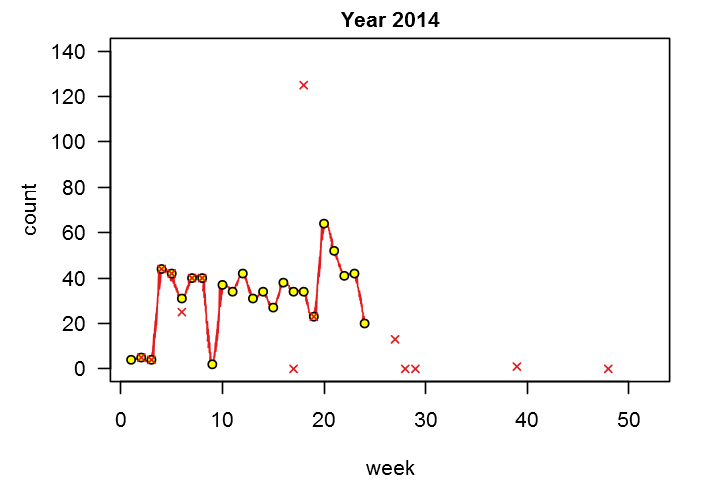

In [24]:
curr_size = c(6,4)
options(repr.plot.width=curr_size[1],repr.plot.height=curr_size[2])
par(mar=c(4,4.5,1.5,2)+.1,las=1)

plot(0:1,xlim=c(1,52),ylim=c(0,140),xlab="week",ylab="count",type="n",main="Year 2014",cex.main=1.02)

# from PlotDigitizer
lines(data2014[,1],data2014[,2],col=clrs_[3])

# Imputed data
df_Imputed %>% filter(Year==2014) -> df_
points(df_[['Week']],df_[['Incidence.Imputed']],col='black',bg='yellow',pch=21,cex=.8)

# Known points from EpiReports
df.wide %>% filter(Year==2014) %>% select(Week,Reported.Incidence) %>% na.omit -> df_
points(df_[['Week']],df_[['Reported.Incidence']],col=clrs_[3],pch=4,cex=.8)

Saving the results for further manual imputation to Excel

In [25]:
write.csv(df_Imputed, file="../results/2012-2014_PlotDigitizer.csv", row.names = FALSE)